In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from google.colab import files

In [ ]:
def clean(df: pd.DataFrame) -> pd.DataFrame:

    df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
    df = df.apply(_fill_nan, axis=0)

    pclass_dummy = pd.get_dummies(df['Pclass'])
    pclass_dummy.rename(
      columns={1:'Pclass1', 2:'Pclass2', 3:'Pclass3'},
      inplace=True
    )
    df = pd.concat([df, pclass_dummy], axis=1)
    df.drop('Pclass', axis=1, inplace=True)

    sex_dummy = pd.get_dummies(df['Sex'])
    df = pd.concat([df, sex_dummy], axis=1)
    df.drop('Sex', axis=1, inplace=True)
    return df

def _fill_nan(series: pd.Series) -> pd.Series:
  if series.dtype is np.dtype(object):
    return series.fillna(series.mode())
  else:
    return series.fillna(series.mean())

In [ ]:
x_train: pd.DataFrame = pd.read_csv('train.csv', index_col=0)
x_test: pd.DataFrame = pd.read_csv('test.csv', index_col=0)
y_train: pd.Series = x_train['Survived']

x_train = clean(x_train)
x_test = clean(x_test)

params = {
    'n_estimators': [i for i in range(1, 502, 10)],
    'max_depth': [i for i in range(1, 52, 2)],
    'criterion': ('gini', 'entropy'),
}

base_rf = RandomForestClassifier(random_state=3)
rf = GridSearchCV(
    base_rf,
    params,
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=5,
    return_train_score=True,
)
rf.fit(x_train, y_train)

results = pd.DataFrame(rf.cv_results_)
results = results[['param_criterion', 'param_n_estimators', 'param_max_depth',
    'mean_test_score', 'rank_test_score', 'mean_train_score']]
results.to_csv('rf_results.csv', index=False)
files.download('rf_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

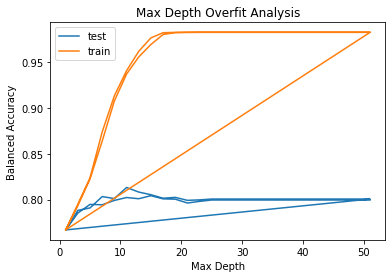

In [ ]:
best = results[results['rank_test_score'] == 1]
max_depth = results[results['param_n_estimators'] == best['param_n_estimators'].values[0]]
plt.plot(max_depth['param_max_depth'], max_depth['mean_test_score'], label='test')
plt.plot(max_depth['param_max_depth'], max_depth['mean_train_score'], label='train')

plt.xlabel('Max Depth')
plt.ylabel('Balanced Accuracy')
plt.title('Max Depth Overfit Analysis')
plt.legend()
plt.savefig('depth.svg', format='svg')
files.download('depth.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

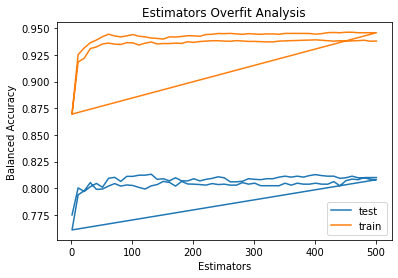

In [ ]:
estimators = results[results['param_max_depth'] == best['param_max_depth'].values[0]]
plt.plot(estimators['param_n_estimators'], estimators['mean_test_score'], label='test')
plt.plot(estimators['param_n_estimators'], estimators['mean_train_score'], label='train')

plt.xlabel('Estimators')
plt.ylabel('Balanced Accuracy')
plt.title('Estimators Overfit Analysis')
plt.legend()
plt.savefig('estimators.svg', format='svg')
files.download('estimators.svg')

In [ ]:
dump(rf, 'rfmodel.joblib')
files.download('rfmodel.joblib')

predictions = pd.DataFrame()
predictions['Survived'] = rf.predict(x_test)
predictions['PassengerId'] = x_test.index
predictions.to_csv('rf_output.csv', index=False)
files.download('rf_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>